# Load Data

In [ ]:
import spacy
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
from nltk.stem import WordNetLemmatizer
# Load the stop words and lemmatizing model
en_model = spacy.load('en_core_web_sm')
stopwords = en_model.Defaults.stop_words
wnl = WordNetLemmatizer()
# create new token list lemmatized, rid of stop words and lower cased
with open('token_list.txt') as f:
  with open('processed_token_list.txt','w') as w:
    for line in f:
      tokens = [token.strip() for token in line.split(',')]
      clean_tokens = [wnl.lemmatize(tokens[i]).lower() for i in range(len(tokens)-1) if wnl.lemmatize(tokens[i]) not in stopwords]
      w.write(','.join(clean_tokens)+'\n')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Error loading corpus: Package 'corpus' not found in index


In [ ]:
token_list_path = '/content/processed_token_list.txt'
data = []
with open(token_list_path) as f:
  for line in f:
    tokens = [token.strip() for token in line.split(',')]
    data.append(" ".join(tokens[:-1]))
print(data)

In [ ]:
# Load Training Labels
labels = []
label_file = 'labels.txt'
with open(label_file) as f:
  for label in f:
    labels.append(int(label.strip()))
f.close()

In [ ]:
# Show emotion distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(df.Emotion)
plt.show()

In [ ]:
# Emotion check
import pandas as pd
emotions = {}
df = pd.read_excel('PERC_mendelly.xlsx')
for i in range(len(df.Emotion)):
  emotions[df.Emotion[i]] = labels[i]
  if len(emotions) >= 9:
    break
print(emotions)
emotions = {k: v for k, v in sorted(emotions.items(), key=lambda item: item[1])}
print(emotions)

In [ ]:
from keras.utils import to_categorical
y_data = to_categorical(labels)

In [ ]:
# Tokenization
from keras.preprocessing.text import Tokenizer
num_words = 10000
tokenizer=Tokenizer(num_words,lower=True)
tokenizer.fit_on_texts(data)

In [ ]:
from keras_preprocessing.sequence import pad_sequences
X_data=tokenizer.texts_to_sequences(data) # this converts texts into some numeric sequences 
X_data_pad=pad_sequences(X_data,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 

In [ ]:
# Smote
from imblearn.over_sampling import SMOTE
smote = SMOTE()
data_resampled, label_resampled = smote.fit_resample(X_data_pad, y_data)

In [ ]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_resampled, label_resampled, test_size=0.1, random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(len(y_train))
print(len(y_val))
print(len(y_test))

(1159, 300)
(145, 300)
(145, 300)
1159
145
145


In [ ]:
print(y_train.shape)
train_count = np.bincount([np.argmax(y) for y in y_train])
val_count = np.bincount([np.argmax(y) for y in y_val])
test_count = np.bincount([np.argmax(y) for y in y_test])
train_tracker = []
val_tracker = []
test_tracker = []
for i in range(9):
  train_tracker.append([i, train_count[i]])
  val_tracker.append([i, val_count[i]])
  test_tracker.append([i, test_count[i]])

print(train_tracker)
print(val_tracker)
print(test_tracker)

(1159, 9)
[[0, 124], [1, 129], [2, 134], [3, 127], [4, 130], [5, 129], [6, 128], [7, 129], [8, 129]]
[[0, 20], [1, 15], [2, 19], [3, 13], [4, 15], [5, 16], [6, 19], [7, 14], [8, 14]]
[[0, 17], [1, 17], [2, 8], [3, 21], [4, 16], [5, 16], [6, 14], [7, 18], [8, 18]]


In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300') #300 dimension

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
import numpy as np
vector_size = 300
weight_matrix = np.zeros((num_words ,vector_size))
weight_matrix.shape

(10000, 300)

In [ ]:
for word, index in tokenizer.word_index.items():
    if index < num_words: 
        if word in glove_gensim.wv.vocab:
            weight_matrix[index] = glove_gensim[word]
        else:
            weight_matrix[index] = np.zeros(300)

<ipython-input-11-ec0691b05ea9>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in glove_gensim.wv.vocab:


**Building the model**

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout

In [ ]:
EMBEDDING_DIM = 300
class_num = 9
model = Sequential()
model.add(Embedding(input_dim = num_words,
                    output_dim = EMBEDDING_DIM,
                    input_length= X_train.shape[1],
                    weights = [weight_matrix],trainable = False))
# model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True, recurrent_regularizer='l2')))
# model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True,recurrent_regularizer='l2')))
# model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False, recurrent_regularizer='l2')))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = 'accuracy')

In [ ]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 40)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_embedding = model.fit(X_train, 
                              y_train, 
                              epochs = 50, 
                              batch_size = 100,
                              #validation_data=(X_val, y_val),
                              validation_split=0.2,
                              verbose = 1, 
                              callbacks= [es, mc])

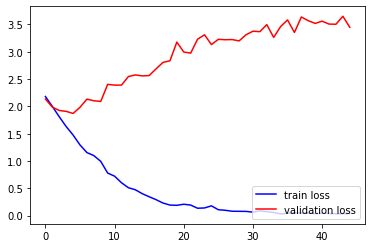

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_embedding.history['loss'], c='b', label='train loss')
plt.plot(history_embedding.history['val_loss'] ,c='r', label='validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred =   np.argmax(model.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

5/5 [==============================] - 1s 56ms/step
              precision    recall  f1-score   support

           0       0.41      0.39      0.40        18
           1       0.29      0.25      0.27        20
           2       0.25      0.18      0.21        11
           3       0.29      0.43      0.34        14
           4       0.31      0.25      0.28        20
           5       0.44      0.35      0.39        20
           6       0.29      0.25      0.27        16
           7       0.33      0.43      0.38        14
           8       0.11      0.17      0.13        12

    accuracy                           0.30       145
   macro avg       0.30      0.30      0.30       145
weighted avg       0.31      0.30      0.30       145

